In [571]:
import pandas as pd
import numpy as np
import random
%matplotlib inline
import matplotlib.pyplot as plt
import surprise
from surprise import SVD, SVDpp, NMF
from surprise import Dataset
from surprise import Reader
from surprise import evaluate, print_perf
from surprise import KNNBasic
from surprise import AlgoBase, BaselineOnly
from get_top_n import get_top_n
from surprise.accuracy import rmse, mae

# Set up training & test data

In [572]:
#Load data
dt = pd.read_csv('sample_data.csv',index_col=0)
dt.head()

,reviewerID,productID,rating,date
370183,A2OR4QUQSUMOW7,B0016B9FSU,4.0,2013-01-31
370186,A14E7LZASLSX36,B0016B9FSU,5.0,2013-03-21
370189,A9ESHA5MS6S6L,B0016B9FSU,5.0,2013-01-17
370192,ATATZGNDHA5ZD,B0016B9FSU,5.0,2013-02-05
370193,AN4HRAGRHHX1H,B0016B9FSU,5.0,2013-01-03


In [573]:
#Construct missing ratings we need to predict
select_data = dt.pivot_table('rating',index=['reviewerID','productID'],dropna=False)
select_data = select_data.loc[select_data['rating'].isnull()]
select_data.reset_index(inplace=True)
missing_values = select_data[['reviewerID','productID']].values

In [574]:
reader = Reader(rating_scale=(1,5))
dt = Dataset.load_from_df(dt[['reviewerID','productID','rating']],reader)

In [575]:
raw_ratings = dt.raw_ratings
#Shuffle ratings
random.seed(42)
random.shuffle(raw_ratings)
#Split to training and test sets
threshold = int(.8 * len(raw_ratings))
A_raw_ratings = raw_ratings[:threshold]
B_raw_ratings = raw_ratings[threshold:]

In [576]:
dt.raw_ratings = A_raw_ratings  # dt is now the set A
dt.split(n_folds=3)

In [577]:
#Construct train set and test set for use by surprise
trainset = dt.build_full_trainset() # trainset is set A
testset = dt.construct_testset(B_raw_ratings)  # testset is set B

# Train Models

## Baseline Model

In [578]:
#Baseline model: User's bias & item's bias
class BaselineModel(AlgoBase):

    def __init__(self):
        AlgoBase.__init__(self)

    def compute_bias(self):
        bu = np.zeros(self.trainset.n_users)
        bi = np.zeros(self.trainset.n_items)
        global_mean = self.trainset.global_mean
        
        for i in self.trainset.all_items():
            dev_i = 0
            for (u, r) in self.trainset.ir[i]:
                dev_i += r - global_mean
            bi[i] = dev_i/(len(self.trainset.ir[i]))
        
        for u in self.trainset.all_users():
            dev_u = 0
            for (i, r) in self.trainset.ur[u]:
                dev_u += r - global_mean
            bu[u] = dev_u/(len(self.trainset.ur[u]))
        return bu, bi
    
    def train(self, trainset):
        AlgoBase.train(self, trainset)
        self.bu, self.bi = self.compute_bias()

    def estimate(self, u, i):
        est = self.trainset.global_mean
        if self.trainset.knows_user(u):
            est += self.bu[u]
        if self.trainset.knows_item(i):
            est += self.bi[i]
        return est

algo1 = BaselineModel()

In [579]:
#Train using baseline model and test on testset
evaluate(algo1,dt,measures=['RMSE','MAE'], verbose= 1)
baseline_predictions = algo1.test(testset)

Evaluating RMSE, MAE of algorithm BaselineModel.

------------
Fold 1
RMSE: 1.0403
MAE:  0.7736
------------
Fold 2
RMSE: 1.0510
MAE:  0.7872
------------
Fold 3
RMSE: 1.0457
MAE:  0.7947
------------
------------
Mean RMSE: 1.0457
Mean MAE : 0.7852
------------
------------


In [580]:
#Accuracy on test set
rmse(baseline_predictions)
mae(baseline_predictions)

RMSE: 1.0790
MAE:  0.8137


0.81369601807649294

## Model-based Collaborative Filtering

In [581]:
#SVD
algo2 = SVD()
evaluate(algo2,dt,measures=['RMSE','MAE'], verbose= 1)
svd_predictions = algo2.test(testset)

Evaluating RMSE, MAE of algorithm SVD.

------------
Fold 1
RMSE: 0.9473
MAE:  0.7395
------------
Fold 2
RMSE: 0.9385
MAE:  0.7301
------------
Fold 3
RMSE: 0.9333
MAE:  0.7370
------------
------------
Mean RMSE: 0.9397
Mean MAE : 0.7355
------------
------------


In [582]:
#Accuracy on test set
rmse(svd_predictions)
mae(svd_predictions)

RMSE: 0.9658
MAE:  0.7598


0.75982728795393906

#### Changing hyper-parameters of model-based

#Ikya

## KNN Collaborative Filtering

In [583]:
## define algorithm config
algo_name = KNNBasic ##  KNNWithMeans,KNNBaseline
sim_option={'name': 'cosine', ## cosine, msd, pearson, personbaseline
                 'user_based': 'False', ## False for item-based
                 'min_surpport':0 }##  if |Iuv|<min_support then sim(u,v)=0
max_k = 10 ## The (max) number of neighbors to take into account for aggregation
min_k = 1 ##  If there are not enough neighbors, the prediction is set the the global mean of all ratings

In [584]:
knn_default = algo_name(k = max_k, min_k = min_k, sim_options=sim_option)

In [585]:
#Train model
perf = evaluate(knn_default, dt, measures=['RMSE','MAE'], verbose= 1)
defaultknn_prediction=knn_default.test(testset)

Evaluating RMSE, MAE of algorithm KNNBasic.

------------
Fold 1
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9843
MAE:  0.7628
------------
Fold 2
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.0004
MAE:  0.7638
------------
Fold 3
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9874
MAE:  0.7754
------------
------------
Mean RMSE: 0.9907
Mean MAE : 0.7673
------------
------------


In [586]:
#Accuracy on test set
rmse(defaultknn_prediction)
mae(defaultknn_prediction)

RMSE: 1.0166
MAE:  0.7935


0.79354121595335447

#### Changing hyper-paramater of KNN

In [587]:
algo_name = KNNBasic
#Define the different hyper-paramter range
grid_param = {'k':[5,10,20,30,35,40,50],
             'min_k':[1,3,5,7],
             'sim_options':{'name':['msd','cosine','pearson'],
                           'min_surpport':[0,3,5],
                           'user_based':[False]}
             }

In [588]:
grid_search = surprise.GridSearch(algo_name, grid_param, measures=['RMSE', 'MAE'],verbose = 1)
grid_search.evaluate(dt)

[{'k': 5, 'min_k': 1, 'sim_options': {'name': 'msd', 'min_surpport': 0, 'user_based': False}}, {'k': 5, 'min_k': 1, 'sim_options': {'name': 'msd', 'min_surpport': 3, 'user_based': False}}, {'k': 5, 'min_k': 1, 'sim_options': {'name': 'msd', 'min_surpport': 5, 'user_based': False}}, {'k': 5, 'min_k': 1, 'sim_options': {'name': 'cosine', 'min_surpport': 0, 'user_based': False}}, {'k': 5, 'min_k': 1, 'sim_options': {'name': 'cosine', 'min_surpport': 3, 'user_based': False}}, {'k': 5, 'min_k': 1, 'sim_options': {'name': 'cosine', 'min_surpport': 5, 'user_based': False}}, {'k': 5, 'min_k': 1, 'sim_options': {'name': 'pearson', 'min_surpport': 0, 'user_based': False}}, {'k': 5, 'min_k': 1, 'sim_options': {'name': 'pearson', 'min_surpport': 3, 'user_based': False}}, {'k': 5, 'min_k': 1, 'sim_options': {'name': 'pearson', 'min_surpport': 5, 'user_based': False}}, {'k': 5, 'min_k': 3, 'sim_options': {'name': 'msd', 'min_surpport': 0, 'user_based': False}}, {'k': 5, 'min_k': 3, 'sim_options': {'

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
------------
Mean RMSE: 1.1335
Mean MAE : 0.8490
------------
------------
Parameters combination 2 of 252
params:  {'k': 5, 'min_k': 1, 'sim_options': {'name': 'msd', 'min_surpport': 3, 'user_based': False}}
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
------------
Mean RMSE: 1.1335
Mean MAE : 0.8490
------------
------------
Parameters combination 3 of 252
params:  {'k': 5, 'min_k': 1, 'sim_options': {'name': 'msd', 'min_surpport': 5, 'user_based': False}}
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix

------------
Mean RMSE: 1.0388
Mean MAE : 0.8016
------------
------------
Parameters combination 21 of 252
params:  {'k': 5, 'min_k': 5, 'sim_options': {'name': 'msd', 'min_surpport': 5, 'user_based': False}}
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
------------
Mean RMSE: 1.0388
Mean MAE : 0.8016
------------
------------
Parameters combination 22 of 252
params:  {'k': 5, 'min_k': 5, 'sim_options': {'name': 'cosine', 'min_surpport': 0, 'user_based': False}}
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
------------
Mean RMSE: 1.0602
Mean MAE : 0.8175
------------
------------
Parameters combination 23 of 252
params:  {'k': 5, 'min

------------
Mean RMSE: 1.1262
Mean MAE : 0.8476
------------
------------
Parameters combination 40 of 252
params:  {'k': 10, 'min_k': 1, 'sim_options': {'name': 'cosine', 'min_surpport': 0, 'user_based': False}}
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
------------
Mean RMSE: 1.1421
Mean MAE : 0.8625
------------
------------
Parameters combination 41 of 252
params:  {'k': 10, 'min_k': 1, 'sim_options': {'name': 'cosine', 'min_surpport': 3, 'user_based': False}}
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
------------
Mean RMSE: 1.1421
Mean MAE : 0.8625
------------
------------
Parameters combination 42 of 252
params: 

Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
------------
Mean RMSE: 1.0470
Mean MAE : 0.8130
------------
------------
Parameters combination 60 of 252
params:  {'k': 10, 'min_k': 5, 'sim_options': {'name': 'cosine', 'min_surpport': 5, 'user_based': False}}
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
------------
Mean RMSE: 1.0470
Mean MAE : 0.8130
------------
------------
Parameters combination 61 of 252
params:  {'k': 10, 'min_k': 5, 'sim_options': {'name': 'pearson', 'min_surpport': 0, 'user_based': False}}
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
--

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
------------
Mean RMSE: 1.1609
Mean MAE : 0.8760
------------
------------
Parameters combination 80 of 252
params:  {'k': 20, 'min_k': 1, 'sim_options': {'name': 'pearson', 'min_surpport': 3, 'user_based': False}}
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
------------
Mean RMSE: 1.1609
Mean MAE : 0.8760
------------
------------
Parameters combination 81 of 252
params:  {'k': 20, 'min_k': 1, 'sim_options': {'name': 'pearson', 'min_surpport': 5, 'user_based': False}}
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarit

------------
Parameters combination 100 of 252
params:  {'k': 20, 'min_k': 7, 'sim_options': {'name': 'msd', 'min_surpport': 0, 'user_based': False}}
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
------------
Mean RMSE: 1.0294
Mean MAE : 0.7981
------------
------------
Parameters combination 101 of 252
params:  {'k': 20, 'min_k': 7, 'sim_options': {'name': 'msd', 'min_surpport': 3, 'user_based': False}}
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
------------
Mean RMSE: 1.0294
Mean MAE : 0.7981
------------
------------
Parameters combination 102 of 252
params:  {'k': 20, 'min_k': 7, 'sim_options': {'name': 'msd', 'min_surpport': 5, 'user_base

Computing the msd similarity matrix...
Done computing similarity matrix.
------------
Mean RMSE: 1.0403
Mean MAE : 0.8042
------------
------------
Parameters combination 120 of 252
params:  {'k': 30, 'min_k': 3, 'sim_options': {'name': 'msd', 'min_surpport': 5, 'user_based': False}}
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
------------
Mean RMSE: 1.0403
Mean MAE : 0.8042
------------
------------
Parameters combination 121 of 252
params:  {'k': 30, 'min_k': 3, 'sim_options': {'name': 'cosine', 'min_surpport': 0, 'user_based': False}}
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
------------
Mean RMSE: 1.0530
Mean MAE : 0.8176
----

Computing the msd similarity matrix...
Done computing similarity matrix.
------------
Mean RMSE: 1.0309
Mean MAE : 0.7995
------------
------------
Parameters combination 139 of 252
params:  {'k': 30, 'min_k': 7, 'sim_options': {'name': 'cosine', 'min_surpport': 0, 'user_based': False}}
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
------------
Mean RMSE: 1.0416
Mean MAE : 0.8102
------------
------------
Parameters combination 140 of 252
params:  {'k': 30, 'min_k': 7, 'sim_options': {'name': 'cosine', 'min_surpport': 3, 'user_based': False}}
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
------------
Mean RMSE: 1.0416
Mean MAE :

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
------------
Mean RMSE: 1.0532
Mean MAE : 0.8177
------------
------------
Parameters combination 158 of 252
params:  {'k': 35, 'min_k': 3, 'sim_options': {'name': 'cosine', 'min_surpport': 3, 'user_based': False}}
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
------------
Mean RMSE: 1.0532
Mean MAE : 0.8177
------------
------------
Parameters combination 159 of 252
params:  {'k': 35, 'min_k': 3, 'sim_options': {'name': 'cosine', 'min_surpport': 5, 'user_based': False}}
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix

Parameters combination 177 of 252
params:  {'k': 35, 'min_k': 7, 'sim_options': {'name': 'cosine', 'min_surpport': 5, 'user_based': False}}
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
------------
Mean RMSE: 1.0418
Mean MAE : 0.8103
------------
------------
Parameters combination 178 of 252
params:  {'k': 35, 'min_k': 7, 'sim_options': {'name': 'pearson', 'min_surpport': 0, 'user_based': False}}
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
------------
Mean RMSE: 1.0436
Mean MAE : 0.8111
------------
------------
Parameters combination 179 of 252
params:  {'k': 35, 'min_k': 7, 'sim_options': {'name': 'pearson', 'min_surpp

------------
Parameters combination 197 of 252
params:  {'k': 40, 'min_k': 3, 'sim_options': {'name': 'pearson', 'min_surpport': 3, 'user_based': False}}
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
------------
Mean RMSE: 1.0559
Mean MAE : 0.8191
------------
------------
Parameters combination 198 of 252
params:  {'k': 40, 'min_k': 3, 'sim_options': {'name': 'pearson', 'min_surpport': 5, 'user_based': False}}
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
------------
Mean RMSE: 1.0559
Mean MAE : 0.8191
------------
------------
Parameters combination 199 of 252
params:  {'k': 40, 'min_k': 5, 'sim_options': {'name': 'msd

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
------------
Mean RMSE: 1.0436
Mean MAE : 0.8111
------------
------------
Parameters combination 216 of 252
params:  {'k': 40, 'min_k': 7, 'sim_options': {'name': 'pearson', 'min_surpport': 5, 'user_based': False}}
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
------------
Mean RMSE: 1.0436
Mean MAE : 0.8111
------------
------------
Parameters combination 217 of 252
params:  {'k': 50, 'min_k': 1, 'sim_options': {'name': 'msd', 'min_surpport': 0, 'user_based': False}}
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Do

Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
------------
Mean RMSE: 1.0559
Mean MAE : 0.8191
------------
------------
Parameters combination 235 of 252
params:  {'k': 50, 'min_k': 5, 'sim_options': {'name': 'msd', 'min_surpport': 0, 'user_based': False}}
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
------------
Mean RMSE: 1.0332
Mean MAE : 0.8033
------------
------------
Parameters combination 236 of 252
params:  {'k': 50, 'min_k': 5, 'sim_options': {'name': 'msd', 'min_surpport': 3, 'user_based': False}}
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
------------
Mean RMSE: 1.0

In [589]:
grid_search.best_params['RMSE']

{'k': 10,
 'min_k': 7,
 'sim_options': {'min_surpport': 0, 'name': 'msd', 'user_based': False}}

In [590]:
grid_search.best_score['RMSE']

1.0290302751938731

In [591]:
grid_search.best_params['MAE']

{'k': 10,
 'min_k': 7,
 'sim_options': {'min_surpport': 0, 'name': 'msd', 'user_based': False}}

In [592]:
grid_search.best_score['MAE']

0.79670713276468963

In [593]:
### get the result of different hyper-parameter

In [594]:
#
results_df = pd.DataFrame.from_dict(grid_search.cv_results)
plotdata = results_df.loc[:,['MAE','RMSE','k','min_k']]
name_list = []
min_surppot_list = []
for param in results_df.params:
#     print(param)
    name_list.append(param['sim_options']['name'])
    min_surppot_list.append(param['sim_options']['min_surpport'])
    
name_list = pd.Series(name_list)
min_surppot_list = pd.Series(min_surppot_list)

plotdata['sim_matric'] = name_list
plotdata['min_support'] = min_surppot_list
plotdata.head()

,MAE,RMSE,k,min_k,sim_matric,min_support
0,0.849017,1.133507,5,1,msd,0
1,0.849017,1.133507,5,1,msd,3
2,0.849017,1.133507,5,1,msd,5
3,0.866965,1.154165,5,1,cosine,0
4,0.866965,1.154165,5,1,cosine,3


In [595]:
plotdata_max_k = plotdata[plotdata.min_k == 1]
plotdata_max_k = plotdata_max_k[plotdata_max_k.min_support == 0]
plotdata_max_k = plotdata_max_k[plotdata_max_k.sim_matric == 'cosine']
plotdata_max_k

,MAE,RMSE,k,min_k,sim_matric,min_support
3,0.866965,1.154165,5,1,cosine,0
39,0.862469,1.142119,10,1,cosine,0
75,0.863714,1.139934,20,1,cosine,0
111,0.864696,1.140453,30,1,cosine,0
147,0.864822,1.140637,35,1,cosine,0
183,0.864973,1.140749,40,1,cosine,0
219,0.864973,1.140749,50,1,cosine,0


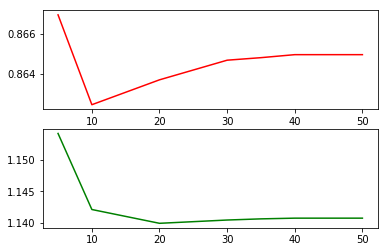

In [596]:
plt.subplot(2, 1, 1) 
plt.plot(plotdata_max_k.k, plotdata_max_k.MAE, 'r')
plt.subplot(2, 1, 2)
plt.plot(plotdata_max_k.k, plotdata_max_k.RMSE, 'g')
plt.show()

In [597]:
plotdata_mink = plotdata[plotdata.sim_matric =='cosine']
plotdata_mink = plotdata_mink[plotdata_mink.min_support == 0]
plotdata_mink = plotdata_mink[plotdata_mink.k == 10]
plotdata_mink

,MAE,RMSE,k,min_k,sim_matric,min_support
183,0.864973,1.140749,40,1,cosine,0
192,0.817844,1.053371,40,3,cosine,0
201,0.815545,1.045538,40,5,cosine,0
210,0.810437,1.041895,40,7,cosine,0


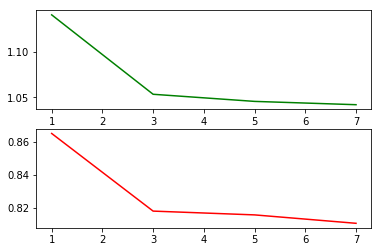

In [598]:
plt.subplot(2, 1, 2) 
plt.plot(plotdata_mink.min_k, plotdata_mink.MAE, 'r')
plt.subplot(2, 1, 1)
plt.plot(plotdata_mink.min_k, plotdata_mink.RMSE, 'g')
plt.show()

In [599]:
plotdata_sim = plotdata[plotdata.min_k ==1]
plotdata_sim = plotdata_sim[plotdata_sim.min_support == 0]
plotdata_sim = plotdata_sim[plotdata_sim.k == 10]
plotdata_sim

,MAE,RMSE,k,min_k,sim_matric,min_support
180,0.850682,1.128388,40,1,msd,0
183,0.864973,1.140749,40,1,cosine,0
186,0.875957,1.160948,40,1,pearson,0


# Metrics - Coverage

In [600]:
#Function to calculate coverage ratio
def coverage_ratio(predictions, n):
    top_n = get_top_n(predictions, n)
    product_list = []
    recommended_list = []
    for uid, iid, true_r, est, _ in predictions:
        product_list.append(iid)
    for uid, user_ratings in top_n.items():
        recommended_list.append(user_ratings[0][0])
    coverage = float(len(set(recommended_list))) / float(len(set(product_list)))
    return coverage

In [601]:
#Function to predict missing values based on an algorithm
def mv_prediction(algo,missing_values):
    predictions = [algo.predict(uid, iid)
                       for (uid, iid) in missing_values]
    return predictions

SVD Coverage Ratio

In [602]:
mv_svdprediction = mv_prediction(algo2,missing_values)
coverage_ratio(mv_svdprediction,7)

0.22857142857142856

KNN Coverage ratio

In [603]:
mv_knnprediction = mv_prediction(knn_default,missing_values)
coverage_ratio(mv_knnprediction,7)

0.3